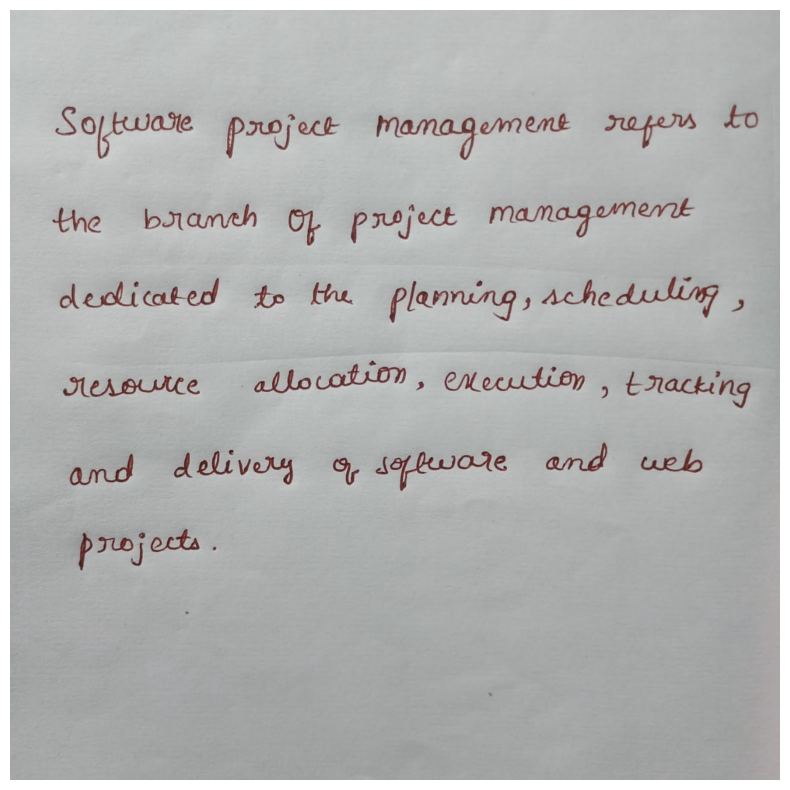

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2

# read the image, check if its 3 channel or grayscale, based on
# that convert to grayscale
img = cv2.imread("/content/drive/MyDrive/train1.jpg")

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show() # preview

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


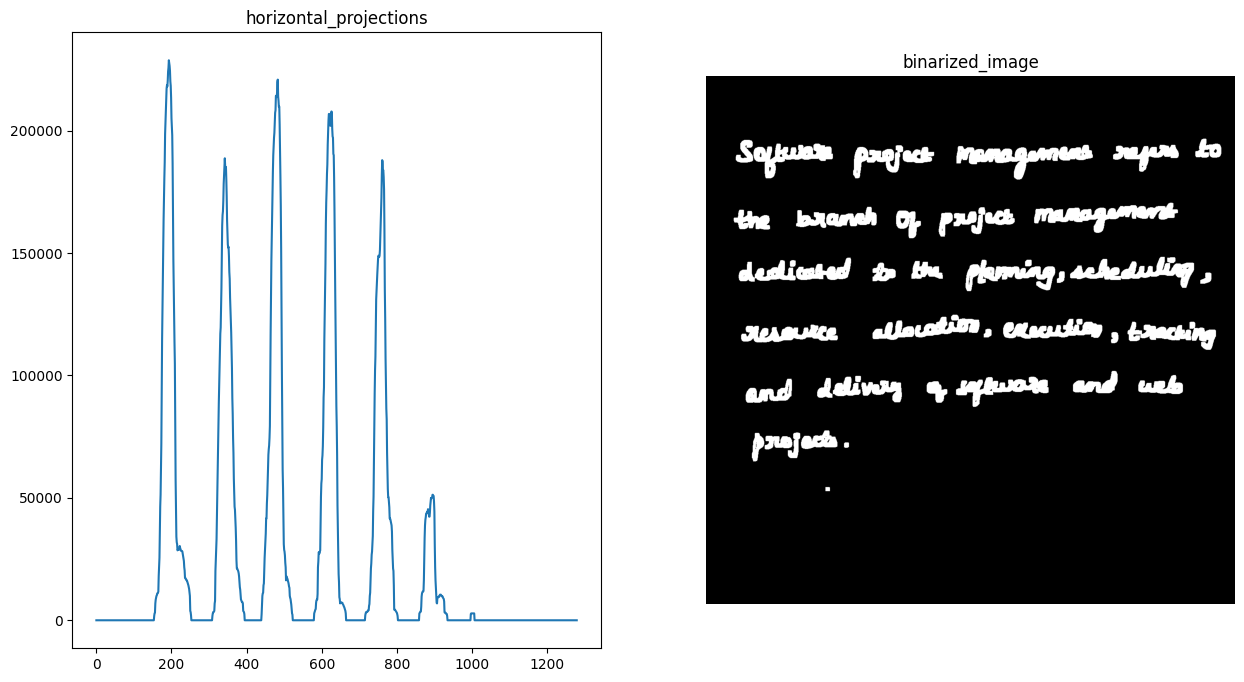

In [ ]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)

def sauvola_thresholding(image, window_size=25, k=0.4, R=128):
    # Convert image to float
    image = image.astype(np.float64)
    # Calculate the mean and standard deviation for each window
    mean = cv2.boxFilter(image, cv2.CV_64F, (window_size, window_size))
    sq_mean = cv2.boxFilter(image**2, cv2.CV_64F, (window_size, window_size))
    variance = sq_mean - mean**2
    stddev = np.sqrt(variance)
    # Calculate Sauvola threshold
    threshold = mean * (1 + k * ((stddev / R) - 1))
    # Apply threshold to binarize the image
    binary_image = (image > threshold).astype(np.uint8) * 255
    return 255-binary_image

def edges_detect(img_gray):
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
    # Sobel Edge Detection
    sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
    sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3)
    edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
    return edges


# check if its 3 channel or grayscale, based on that convert to grayscale
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
original_img=img.copy()
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#remove the noise
blurred_image = cv2.GaussianBlur(img, (3, 3), 0)
edges = edges_detect(blurred_image)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
dilated_image = cv2.dilate(edges, kernel, iterations=1)

# Apply Sauvola thresholding
binary_image = sauvola_thresholding(dilated_image)
_, binary_image = cv2.threshold(binary_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
hpp = horizontal_projections(binary_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binary_image, cmap="gray")

plt.show()

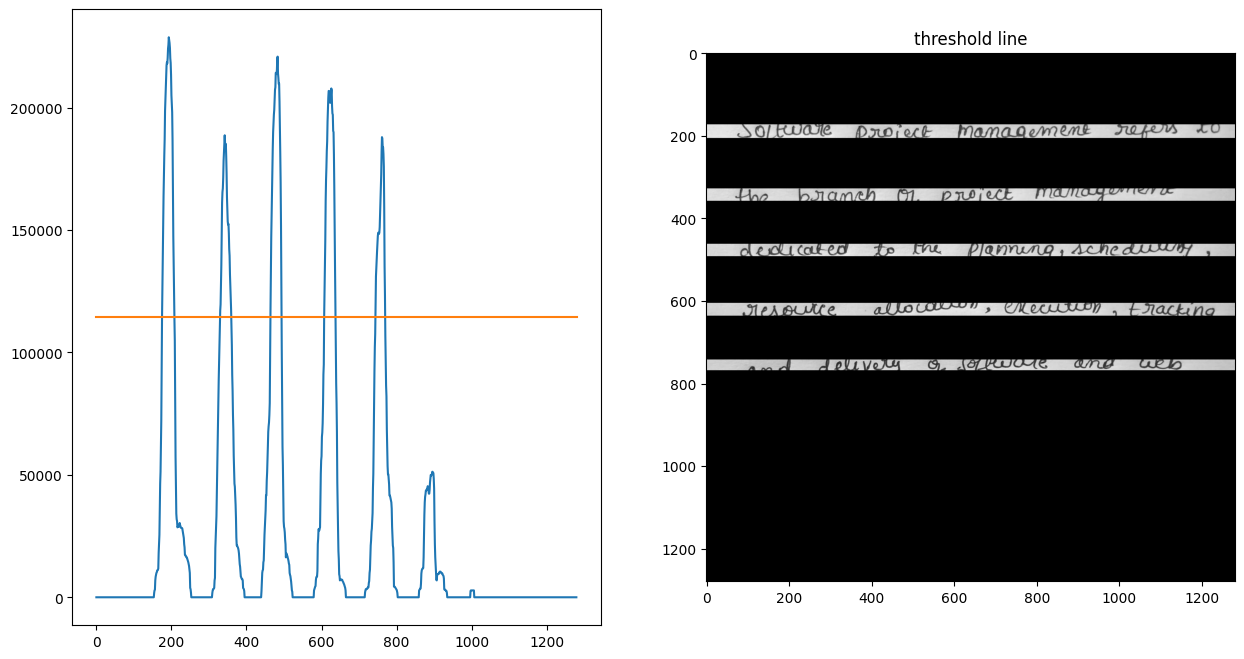

In [ ]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()


In [ ]:
diff_between_consec_numbers = np.diff(peaks_indexes)
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
peak_groups = [item for item in peak_groups if len(item) > 1]
print("peak groups found", len(peak_groups))

peak groups found 6


In [ ]:
#a star path planning algorithm
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))

    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return []

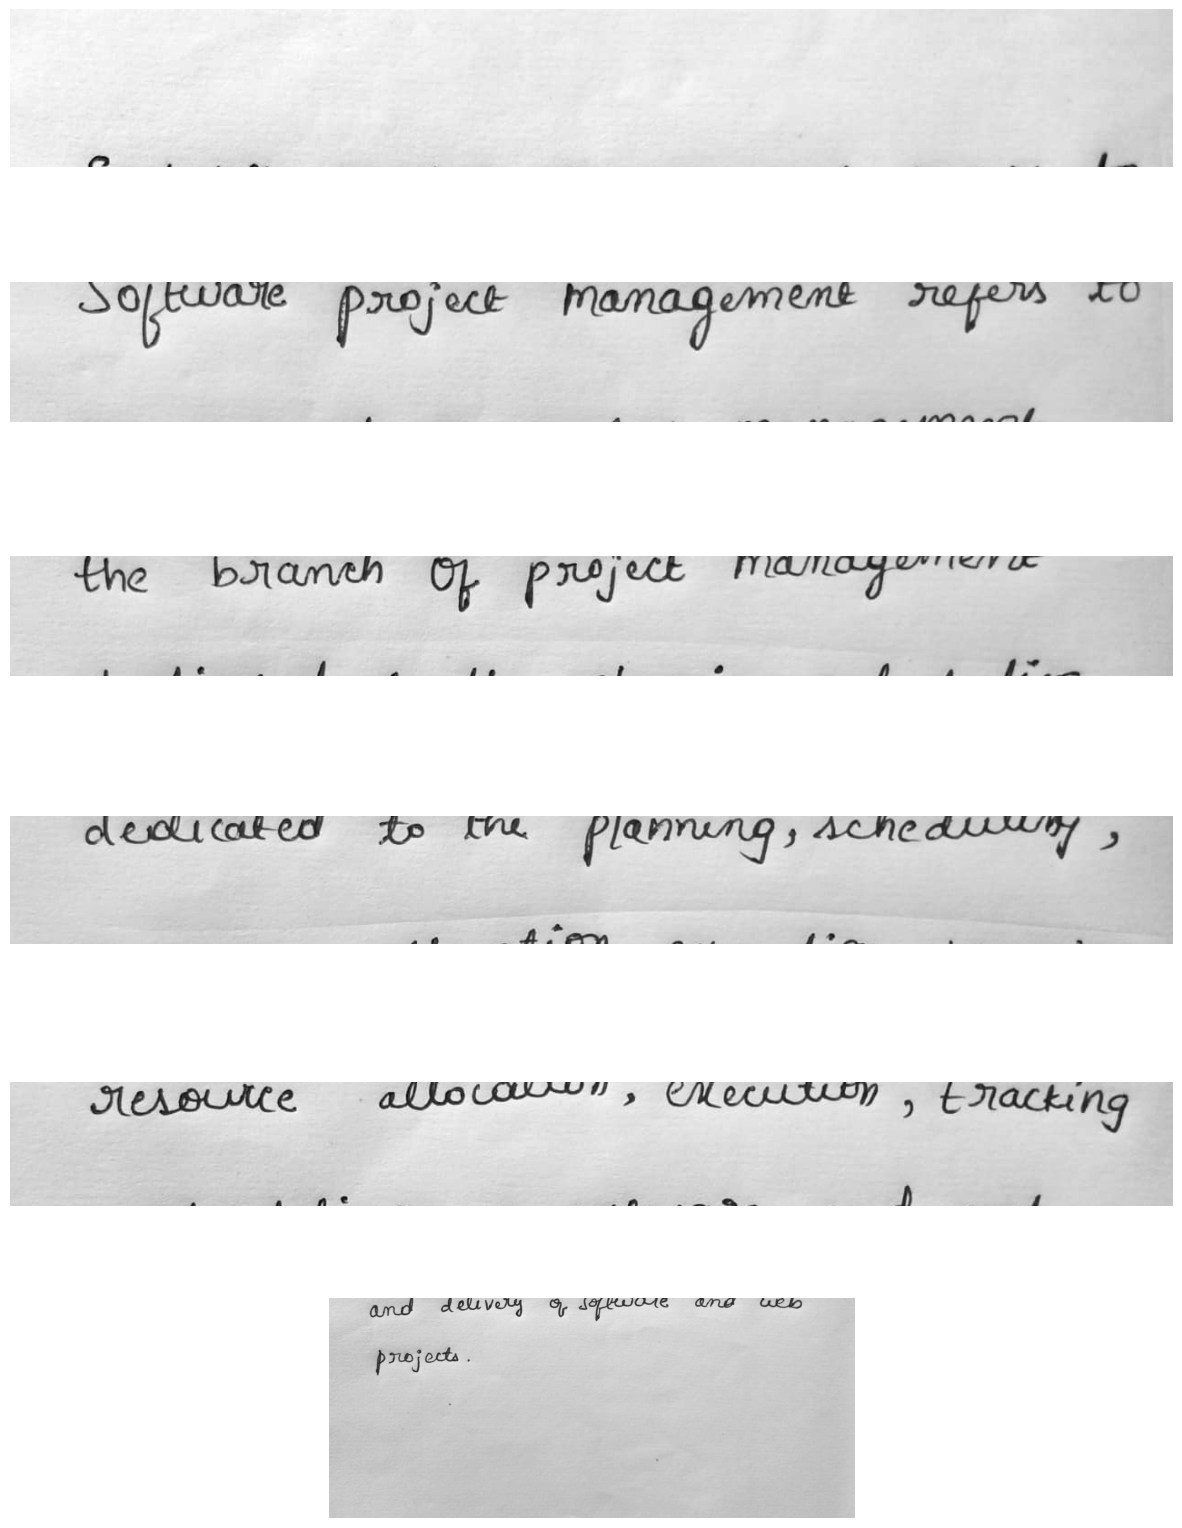

In [ ]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [ ]:
# def get_binary(img):
#     mean = np.mean(img)
#     if mean == 0.0 or mean == 1.0:
#         return img

#     thresh = threshold_otsu(img)
#     binary = img <= thresh
#     binary = binary * 1
#     return binary

# binary_image = get_binary(img)
# segment_separating_lines = []
# for i, sub_image_index in enumerate(peak_groups):
#     nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
#     path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
#     offset_from_top = sub_image_index[0]
#     path[:,0] += offset_from_top
#     segment_separating_lines.append(path)

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary * 1
    return binary

binary_image = get_binary(img)
segment_separating_lines = []
for i, sub_image_index in enumerate(peak_groups):
    nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    # Check if path is not empty before attempting to index it
    if path.size > 0:  # or if len(path.shape) > 1: for strictly checking 2D
        offset_from_top = sub_image_index[0]
        path[:,0] += offset_from_top
        segment_separating_lines.append(path)
    else:
        # Handle cases where astar returns an empty path (e.g., skip, log, etc.)
        print(f"Warning: astar returned an empty path for peak group index {i}")
        # You might choose to skip, log this, or investigate further

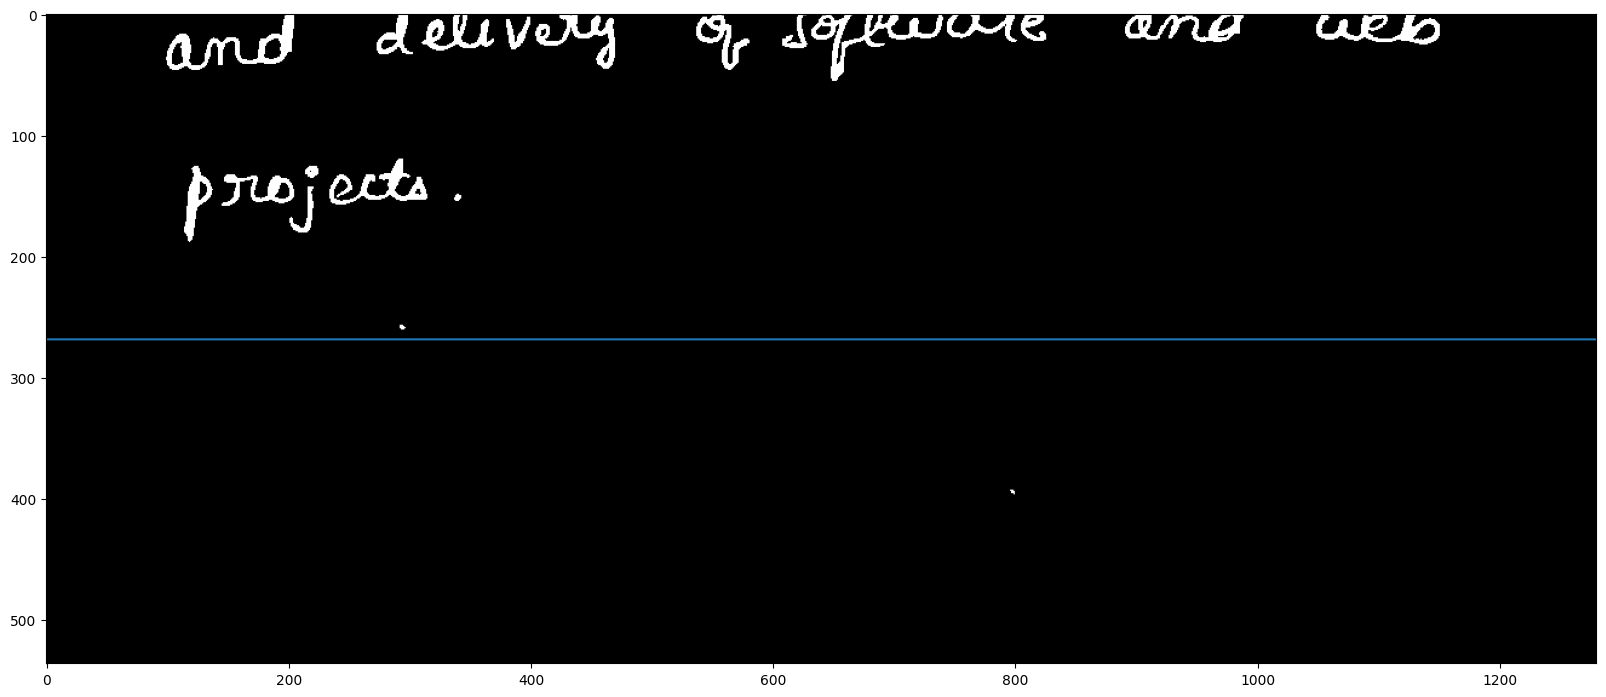

In [ ]:
# visualize a sample
cluster_of_interest = peak_groups[-1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))

# Check if the path is valid before plotting
if path.ndim > 1 and path.size > 0:
    plt.plot(path[:,1], path[:,0])
else:
    print("Warning: astar returned an empty or invalid path. Skipping plotting.")

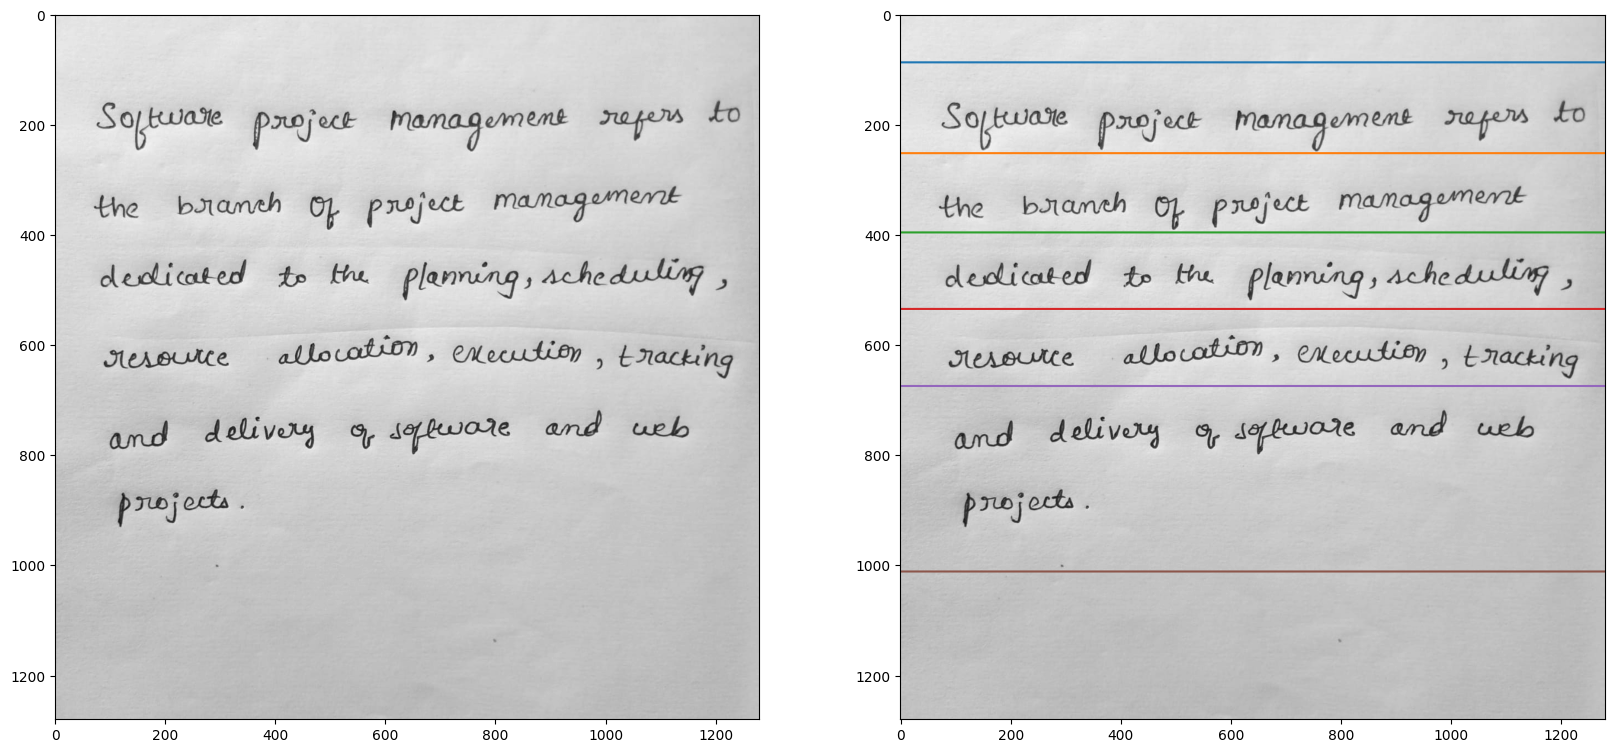

In [ ]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

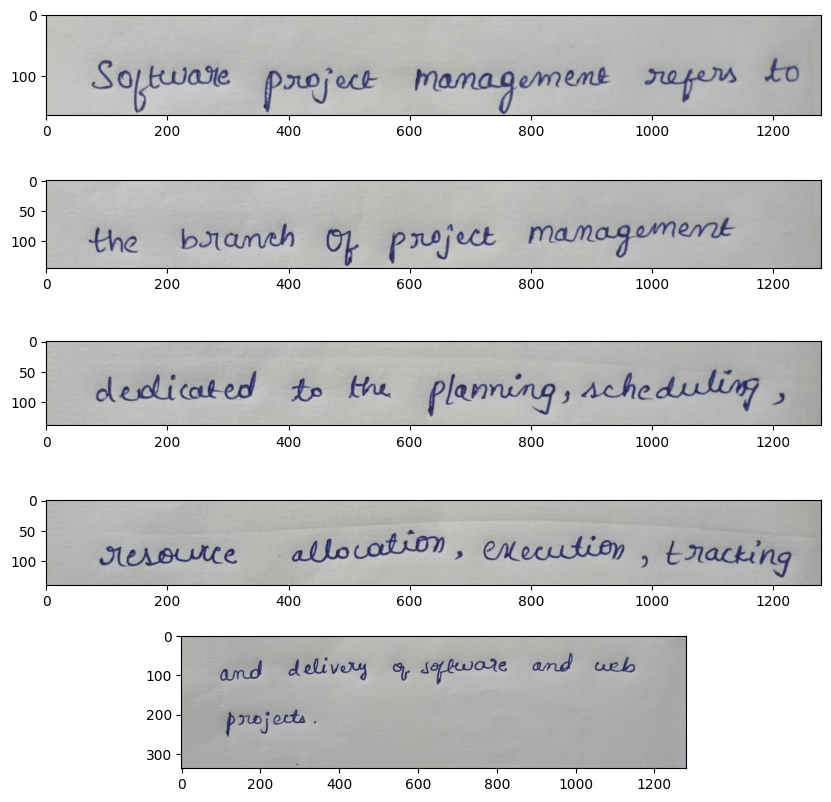

In [ ]:
# TODO: the below splitting image algorithm is too simple
# I need to write a cleaner one.

seperated_images = []
for index, line_segments in enumerate(segment_separating_lines):
    if index < len(segment_separating_lines)-1:
        lower_line = np.min(segment_separating_lines[index][:,0])
        upper_line = np.max(segment_separating_lines[index+1][:,0])
        seperated_images.append(original_img[lower_line:upper_line])

# visualize it
fig, ax = plt.subplots(figsize=(10,10), nrows=len(seperated_images))
for index, line_image in enumerate(seperated_images):
    ax[index].imshow(line_image, cmap="gray")

plt.show()

In [ ]:
!pip install transformers datasets torch torchvision
!pip install pillow  # for image processing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# processor = TrOCRProcessor.from_pretrained('ocr_processor')
# model = VisionEncoderDecoderModel.from_pretrained('ocr_model')
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# import cv2

# def segment_words(line_image, peak_groups, min_Size=100):
#     word_images = []

#     # Iterate through line segments in peak_groups
#     for sub_image_index in peak_groups:
#         # Crop out the segmented line from the binary image
#         # Ensure slicing indices are within bounds
#         lower_bound = max(0, sub_image_index[0])  # Prevent negative index
#         upper_bound = min(line_image.shape[0], sub_image_index[-1])  # Prevent exceeding image height
#         line_segment = line_image[lower_bound:upper_bound, :]

#         # Check if the line segment is empty after slicing
#         if line_segment.size == 0:
#             print("Warning: Empty line segment encountered. Skipping.")
#             continue

#         # Convert line_segment to 8-bit unsigned integer (grayscale) before applying connected components
#         # Convert only if it's not already grayscale
#         if len(line_segment.shape) == 3:  # Check if it has 3 channels (color)
#             line_segment = cv2.cvtColor(line_segment.astype(np.uint8), cv2.COLOR_BGR2GRAY)

#         # Apply connected components to find words within the line
#         num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(line_segment.astype(np.uint8), connectivity=8)

#         for i in range(1, num_labels):  # Skip background
#             x, y, w, h, area = stats[i]
#             if area > min_Size:  # Filter out small artifacts
#                 word_image = line_segment[y:y+h, x:x+w]
#                 word_images.append(word_image)

#     return word_images

In [ ]:
text=""
for index, line_image in enumerate(seperated_images):
    pixel_values = processor(images=line_image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    text=text+" "+generated_text

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
text

' Software project management refers to the branch of project management dedicated to the planning scheduling , resource allocation , execution , tracking # # delivery or software and web'

In [ ]:
from transformers import pipeline
summarizer=pipeline("summarization",model="text_summarizer")

OSError: text_summarizer is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
summary = summarizer(text,max_length=12)
summary[0]['summary_text']

'Text summarization refers to the technique of Shortening'

scoring methods

In [ ]:
# Install necessary libraries
!pip install spacy scikit-learn fuzzywuzzy networkx nltk rdflib transformers
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install scikit-fuzzy


In [ ]:
# import spacy
# from spacy.matcher import Matcher
# import language__tool_python
# #can be improved using hybrid approach
# def languge_score(text):
#     tool = language_tool_python.LanguageTool('en-US')
#     error_count = len(matches)
#     max_errors=50
#     language_score = max(0, 100 - (error_count / max_errors) * 100)
#     return language_score
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# def keyword_extraction_and_similarity_score(text,original_text):
#     vectorizer=TfidfVectorizer()
#     tfidf_matrix=vectorizer.fit_transform([text,original_text])
#     cosine_sim=cosine_similarity(tfidf_matrix[0:1],tfidf_matrix[1:2])
#     cosine_score=cosine_sim[0][0]*100
#     return cosine_score
# from fuzzywuzzy import fuzz
# def fuzzy_score(text,original_text):
#     fuzzy_score=fuzz.ratio(text,original_text)
#     return fuzzy
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# def topic_modelling(text):
#   processed_texts = [[word for word in text.lower().split()] for text in texts]
#   dictionary = corpora.Dictionary(processed_texts)
#   corpus = [dictionary.doc2bow(text) for text in processed_texts]
#   lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=15)
#   for idx, topic in lda_model.print_topics(-1):
#     print(f"Topic {idx + 1}: {topic}")

In [ ]:
# #graph construction
# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import combinations
# from collections import defaultdict

# def extract_cooccurrence_relationships(concepts, text, window_size=5, threshold=2):
#     words = text.split()
#     relationships = defaultdict(int)

#     for i in range(len(words)):
#         window = words[i:i + window_size]
#         for concept1, concept2 in combinations(concepts, 2):
#             if concept1 in window and concept2 in window:
#                 relationships[(concept1, concept2)] += 1
#     filtered_relationships = {pair: count for pair, count in relationships.items() if count >= threshold}
#     return filtered_relationships
# import spacy
# nlp = spacy.load("en_core_web_sm")

# def extract_dependency_relationships(concepts, text):
#     doc = nlp(text)
#     relationships = []

#     for token in doc:
#         if token.dep_ in ("nsubj", "dobj", "prep", "compound"):
#             # Check if token and its head (related term) are both concepts
#             if token.text in concepts and token.head.text in concepts:
#                 relationships.append((token.head.text, token.text, token.dep_))
#             elif token.head.text in concepts and token.text in concepts:
#                 relationships.append((token.text, token.head.text, token.dep_))

#     return relationships
# def graph(concepts, text):
#     cooccurrence_relationships = extract_cooccurrence_relationships(concepts, text)
#     dependency_relationships = extract_dependency_relationships(concepts, text)
#     concept_graph = nx.DiGraph()
#     for (concept1, concept2), count in relationships.items():
#       concept_graph.add_edge(concept1, concept2, label="co-occurrence", weight=count)
#     for (concept1, concept2, dep) in dependency_relationships:
#       concept_graph.add_edge(concept1, concept2, label=f"dependency ({dep})", weight=1)

In [ ]:
# #graph comparision
# from nltk.corpus import wordnet
# from sklearn.metrics.pairwise import cosine_similarity
# from sentence_transformers import SentenceTransformer
# def semantic_similarity(text, original_text):
#   synonyms1 = wordnet.synsets(node1)
#   synonyms2 = wordnet.synsets(node2)
#   if not synonyms1 or not synonyms2:
#         return 0
#   similarity = max(syn1.wup_similarity(syn2) or 0 for syn1 in synonyms1 for syn2 in synonyms2)
#   return similarity
# def compare_node_similarity(graph1, graph2):
#   matching_nodes = 0
#   total_nodes = max(len(graph1.nodes()), len(graph2.nodes()))
#   for node in graph1.nodes():
#         if node in graph2.nodes():
#             matching_nodes += 1
#   else:
#     for student_node in graph2.nodes():
#       if semantic_similarity(node, student_node) > 0.7:  # Threshold
#           matching_nodes += 1
#           break

#   node_similarity_score = matching_nodes / total_nodes
#   return node_similarity_score
# def calculate_edit_distance(graph1, graph2):
#     try:
#         edit_distance = nx.graph_edit_distance(graph1, graph2)
#         similarity_score = 1 / (1 + edit_distance)
#     except Exception as e:
#         print("Error in edit distance calculation:", e)
#         similarity_score = 0

#     return similarity_score

# def overlap_score(graph1, graph2):
#     matching_edges = len(set(graph1.edges()).intersection(set(graph2.edges())))
#     total_edges = max(len(graph1.edges()), len(graph2.edges()))
#     edge_overlap = matching_edges / total_edges

#     return edge_overlap
# def final_similarity_score(graph1, graph2):
#   node_similarity = compare_node_similarity(graph1, graph2)
#   edit_distance_score = calculate_edit_distance(graph1, graph2)
#   edge_overlap_score = overlap_score(graph1, graph2)
#   final_similarity_score = (0.5 * node_similarity +
#                           0.2 * edit_distance_score +
#                           0.3 * edge_overlap_score)
#   return final_similarity_score

In [ ]:
!pip install language-tool-python

In [ ]:
import spacy
from spacy.matcher import Matcher
import language_tool_python
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from gensim import corpora
from gensim.models import LdaModel
from sentence_transformers import SentenceTransformer
from nltk.corpus import wordnet
import networkx as nx
from collections import defaultdict
from itertools import combinations
nltk.download('wordnet')
 #graph comparision
# from nltk.corpus import wordnet
# from sklearn.metrics.pairwise import cosine_similarity
# from sentence_transformers import SentenceTransformer

# Grammar error score using language tool
def language_score(text):
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(text)  # Check for grammar errors
    error_count = len(matches)
    max_errors = 50
    language_score = max(0, 100 - (error_count / max_errors) * 100)
    return language_score

# Keyword extraction and cosine similarity score
def keyword_extraction_and_similarity_score(text, original_text):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text, original_text])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    cosine_score = cosine_sim[0][0] * 100
    return cosine_score

# Fuzzy string matching score
def fuzzy_score(text, original_text):
    fuzzy_score = fuzz.ratio(text, original_text)
    return fuzzy_score

# Topic modeling (optional)
def topic_modelling(texts):
    processed_texts = [[word for word in text.lower().split()] for text in texts]
    dictionary = corpora.Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=15)
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx + 1}: {topic}")

# Graph construction for concept relationships
def extract_cooccurrence_relationships(concepts, text, window_size=5, threshold=2):
    words = text.split()
    relationships = defaultdict(int)
    for i in range(len(words)):
        window = words[i:i + window_size]
        for concept1, concept2 in combinations(concepts, 2):
            if concept1 in window and concept2 in window:
                relationships[(concept1, concept2)] += 1
    filtered_relationships = {pair: count for pair, count in relationships.items() if count >= threshold}
    return filtered_relationships

nlp = spacy.load("en_core_web_sm")

def extract_dependency_relationships(concepts, text):
    doc = nlp(text)
    relationships = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj", "prep", "compound"):
            if token.text in concepts and token.head.text in concepts:
                relationships.append((token.head.text, token.text, token.dep_))
            elif token.head.text in concepts and token.text in concepts:
                relationships.append((token.text, token.head.text, token.dep_))
    return relationships

def build_concept_graph(concepts, text):
    cooccurrence_relationships = extract_cooccurrence_relationships(concepts, text)
    dependency_relationships = extract_dependency_relationships(concepts, text)
    concept_graph = nx.DiGraph()
    for (concept1, concept2), count in cooccurrence_relationships.items():
        concept_graph.add_edge(concept1, concept2, label="co-occurrence", weight=count)
    for (concept1, concept2, dep) in dependency_relationships:
        concept_graph.add_edge(concept1, concept2, label=f"dependency ({dep})", weight=1)
    return concept_graph

# Graph similarity scores
def compare_node_similarity(graph1, graph2):
    matching_nodes = 0
    total_nodes = max(len(graph1.nodes()), len(graph2.nodes()))
    for node in graph1.nodes():
        if node in graph2.nodes():
            matching_nodes += 1
        else:
            for student_node in graph2.nodes():
                if semantic_similarity(node, student_node) > 0.7:
                    matching_nodes += 1
                    break
    node_similarity_score = matching_nodes / total_nodes
    return node_similarity_score

def semantic_similarity(node1, node2):
    synonyms1 = wordnet.synsets(node1)
    synonyms2 = wordnet.synsets(node2)
    if not synonyms1 or not synonyms2:
        return 0
    similarity = max(syn1.wup_similarity(syn2) or 0 for syn1 in synonyms1 for syn2 in synonyms2)
    return similarity

def calculate_edit_distance(graph1, graph2):
    try:
        edit_distance = nx.graph_edit_distance(graph1, graph2)
        similarity_score = 1 / (1 + edit_distance)
    except Exception as e:
        print("Error in edit distance calculation:", e)
        similarity_score = 0
    return similarity_score

def overlap_score(graph1, graph2):
    matching_edges = len(set(graph1.edges()).intersection(set(graph2.edges())))
    total_edges = max(len(graph1.edges()), len(graph2.edges()))
    edge_overlap = matching_edges / total_edges
    return edge_overlap

def final_similarity_score(graph1, graph2):
    node_similarity = compare_node_similarity(graph1, graph2)
    edit_distance_score = calculate_edit_distance(graph1, graph2)
    edge_overlap_score = overlap_score(graph1, graph2)
    final_score = (0.5 * node_similarity + 0.2 * edit_distance_score + 0.3 * edge_overlap_score)
    return final_score

# Calculate the final score based on all individual scores
def calculate_final_score(original_text, text, weights=None):
    if weights is None:
        weights = {
            'language_score': 0.2,
            'keyword_similarity_score': 0.3,
            'fuzzy_match_score': 0.25,
            'concept_graph_score': 0.25
        }

    language_score_val = language_score(text)
    keyword_similarity_score = keyword_extraction_and_similarity_score(text, original_text)
    fuzzy_match_score = fuzzy_score(text, original_text)

    # Build concept graphs for the original and student answers
    concepts = list(set(original_text.split()) & set(text.split()))
    graph1 = build_concept_graph(concepts, original_text)
    graph2 = build_concept_graph(concepts, text)
    concept_graph_score = final_similarity_score(graph1, graph2)

    # Calculate the weighted final score
    final_score = (language_score_val * weights['language_score'] +
                   keyword_similarity_score * weights['keyword_similarity_score'] +
                   fuzzy_match_score * weights['fuzzy_match_score'] +
                   concept_graph_score * weights['concept_graph_score'])

    return final_score

# Example usage
original_text = "Software project management refers to the branch of project management dedicated to the planning,scheduling, resource allocation, execution,tracking and delivery of software and web projects"
text = text

final_score = calculate_final_score(original_text, text)
print("Final Score:", final_score)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package wordnet to /root/nltk_data...
INFO:language_tool_python.download_lt:Unzipping /tmp/tmplkw_jbvf.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.


Final Score: 69.96937652329146


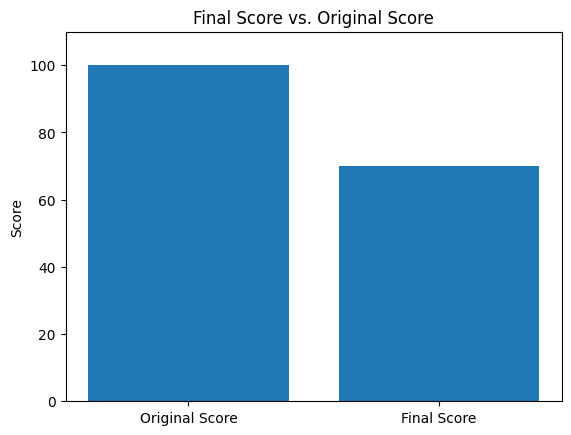

In [ ]:
# prompt: plot the sesmotic graph for the final score comparing with the original score which was 100%

import matplotlib.pyplot as plt

# Assuming 'final_score' is the calculated score and 100 is the original score
scores = [100, final_score]

# Create a bar graph
plt.bar(['Original Score', 'Final Score'], scores)

# Add labels and title
plt.ylabel('Score')
plt.title('Final Score vs. Original Score')

# Customize the graph
plt.ylim(0, 110)  # Adjust the y-axis limits if needed
plt.grid(False)

# Display the graph
plt.show()

In [ ]:
# prompt: generate the code for if the final score is 70-80 then A+ or if the score is 60-70 then A or if the grade if 50-60 then B or if the grade is below fifty fail

def assign_grade(score):
  if 70 <= score <= 80:
    return "A+"
  elif 60 <= score < 70:
    return "A"
  elif 50 <= score < 60:
    return "B"
  else:
    return "Fail"

# Example usage (assuming 'final_score' is defined from the previous code)
grade = assign_grade(final_score)
print(f"The grade for the score is: {grade}")

The grade for the score 69.96937652329146 is: A


In [ ]:
!pip install flask flask-ngrok transformers pillow

In [ ]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import numpy as np
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Starts ngrok when the app is run


@app.route('/evaluate', methods=['POST'])
def evaluate_image():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    file = request.files['file']
    image = Image.open(file.stream).convert("RGB")
    image = np.array(image)

    # Perform text recognition
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Scoring logic
    original_text = "Your reference text here"
    final_score = calculate_final_score(original_text, generated_text)

    return jsonify({'score': final_score})

def calculate_final_score(original, generated):
    # Dummy scoring function; replace with your actual logic
    return len(set(original.split()) & set(generated.split())) / len(original.split()) * 100

# Run the app
app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 199, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [ ]:
# Install ngrok
!pip install flask transformers pillow
!wget -q -O ngrok.zip https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok.zip

# Authenticate ngrok (replace <YOUR_NGROK_TOKEN> with your token)
!./ngrok authtoken <YOUR_NGROK_TOKEN>


Archive:  ngrok.zip
  inflating: ngrok                   
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `./ngrok authtoken <YOUR_NGROK_TOKEN>'


In [ ]:
import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# processor = TrOCRProcessor.from_pretrained('ocr_processor')
# model = VisionEncoderDecoderModel.from_pretrained('ocr_model')
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
#a star path planning algorithm
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))

    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return []
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 1]
def text_from_image(image):
    binary_image = get_binary(img)
    segment_separating_lines = []
    for i, sub_image_index in enumerate(peak_groups):
        nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
        path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
        # Check if path is not empty before attempting to index it
        if path.size > 0:  # or if len(path.shape) > 1: for strictly checking 2D
            offset_from_top = sub_image_index[0]
            path[:,0] += offset_from_top
            segment_separating_lines.append(path)
        else:
            # Handle cases where astar returns an empty path (e.g., skip, log, etc.)
            print(f"Warning: astar returned an empty path for peak group index {i}")
    text=""
    for index, line_image in enumerate(seperated_images):
        pixel_values = processor(images=line_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        text=text+" "+generated_text
    return text

In [ ]:
import spacy
from spacy.matcher import Matcher
import language_tool_python
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from gensim import corpora
from gensim.models import LdaModel
from sentence_transformers import SentenceTransformer
from nltk.corpus import wordnet
import networkx as nx

# Grammar error score using language tool
def language_score(text):
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(text)  # Check for grammar errors
    error_count = len(matches)
    max_errors = 50
    language_score = max(0, 100 - (error_count / max_errors) * 100)
    return language_score

# Keyword extraction and cosine similarity score
def keyword_extraction_and_similarity_score(text, original_text):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text, original_text])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    cosine_score = cosine_sim[0][0] * 100
    return cosine_score

# Fuzzy string matching score
def fuzzy_score(text, original_text):
    fuzzy_score = fuzz.ratio(text, original_text)
    return fuzzy_score

# Topic modeling (optional)
def topic_modelling(texts):
    processed_texts = [[word for word in text.lower().split()] for text in texts]
    dictionary = corpora.Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=15)
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx + 1}: {topic}")

# Graph construction for concept relationships
def extract_cooccurrence_relationships(concepts, text, window_size=5, threshold=2):
    words = text.split()
    relationships = defaultdict(int)
    for i in range(len(words)):
        window = words[i:i + window_size]
        for concept1, concept2 in combinations(concepts, 2):
            if concept1 in window and concept2 in window:
                relationships[(concept1, concept2)] += 1
    filtered_relationships = {pair: count for pair, count in relationships.items() if count >= threshold}
    return filtered_relationships

nlp = spacy.load("en_core_web_sm")

def extract_dependency_relationships(concepts, text):
    doc = nlp(text)
    relationships = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj", "prep", "compound"):
            if token.text in concepts and token.head.text in concepts:
                relationships.append((token.head.text, token.text, token.dep_))
            elif token.head.text in concepts and token.text in concepts:
                relationships.append((token.text, token.head.text, token.dep_))
    return relationships

def build_concept_graph(concepts, text):
    cooccurrence_relationships = extract_cooccurrence_relationships(concepts, text)
    dependency_relationships = extract_dependency_relationships(concepts, text)
    concept_graph = nx.DiGraph()
    for (concept1, concept2), count in cooccurrence_relationships.items():
        concept_graph.add_edge(concept1, concept2, label="co-occurrence", weight=count)
    for (concept1, concept2, dep) in dependency_relationships:
        concept_graph.add_edge(concept1, concept2, label=f"dependency ({dep})", weight=1)
    return concept_graph

# Graph similarity scores
def compare_node_similarity(graph1, graph2):
    matching_nodes = 0
    total_nodes = max(len(graph1.nodes()), len(graph2.nodes()))
    for node in graph1.nodes():
        if node in graph2.nodes():
            matching_nodes += 1
        else:
            for student_node in graph2.nodes():
                if semantic_similarity(node, student_node) > 0.7:
                    matching_nodes += 1
                    break
    node_similarity_score = matching_nodes / total_nodes
    return node_similarity_score

def semantic_similarity(node1, node2):
    synonyms1 = wordnet.synsets(node1)
    synonyms2 = wordnet.synsets(node2)
    if not synonyms1 or not synonyms2:
        return 0
    similarity = max(syn1.wup_similarity(syn2) or 0 for syn1 in synonyms1 for syn2 in synonyms2)
    return similarity

def calculate_edit_distance(graph1, graph2):
    try:
        edit_distance = nx.graph_edit_distance(graph1, graph2)
        similarity_score = 1 / (1 + edit_distance)
    except Exception as e:
        print("Error in edit distance calculation:", e)
        similarity_score = 0
    return similarity_score

def overlap_score(graph1, graph2):
    matching_edges = len(set(graph1.edges()).intersection(set(graph2.edges())))
    total_edges = max(len(graph1.edges()), len(graph2.edges()))
    edge_overlap = matching_edges / total_edges
    return edge_overlap

def final_similarity_score(graph1, graph2):
    node_similarity = compare_node_similarity(graph1, graph2)
    edit_distance_score = calculate_edit_distance(graph1, graph2)
    edge_overlap_score = overlap_score(graph1, graph2)
    final_score = (0.5 * node_similarity + 0.2 * edit_distance_score + 0.3 * edge_overlap_score)
    return final_score

# Calculate the final score based on all individual scores
def calculate_final_score(original_text, text, weights=None):
    if weights is None:
        weights = {
            'language_score': 0.2,
            'keyword_similarity_score': 0.3,
            'fuzzy_match_score': 0.25,
            'concept_graph_score': 0.25
        }

    language_score_val = language_score(text)
    keyword_similarity_score = keyword_extraction_and_similarity_score(text, original_text)
    fuzzy_match_score = fuzzy_score(text, original_text)

    # Build concept graphs for the original and student answers
    concepts = list(set(original_text.split()) & set(text.split()))
    graph1 = build_concept_graph(concepts, original_text)
    graph2 = build_concept_graph(concepts, text)
    concept_graph_score = final_similarity_score(graph1, graph2)

    # Calculate the weighted final score
    final_score = (language_score_val * weights['language_score'] +
                   keyword_similarity_score * weights['keyword_similarity_score'] +
                   fuzzy_match_score * weights['fuzzy_match_score'] +
                   concept_graph_score * weights['concept_graph_score'])

    return final_score

In [ ]:
!pip install fastapi uvicorn jinja2 pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install language_tool_python

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install python-multipart

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install python-multipart

In [ ]:
!ngrok config add-authtoken 2ouxDftjXVObrfnrRAITtJ4ag27_7XCzs3Sn1Anyo8HUgLybb

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from fastapi import FastAPI, File, UploadFile, Form
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from fastapi import FastAPI, Form
from fastapi.responses import HTMLResponse
from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates
from pydantic import BaseModel
from pyngrok import ngrok,conf
from fastapi.requests import Request
import os
import numpy as np

app = FastAPI()
templates_dir = "/content/drive/MyDrive/Colab Notebooks/templates"

# Create the 'static' directory if it doesn't exist
if not os.path.exists("static"):
    os.makedirs("static")

app.mount("/static", StaticFiles(directory="static"), name="static")
templates = Jinja2Templates(directory=templates_dir)
@app.get("/", response_class=HTMLResponse)
def home(request):
    return templates.TemplateResponse("index.html", {"request": request})

import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# processor = TrOCRProcessor.from_pretrained('ocr_processor')
# model = VisionEncoderDecoderModel.from_pretrained('ocr_model')
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
#a star path planning algorithm
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))

    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return []
def find_peak_regions(hpp, threshold):

    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.

def text_from_image(image):
  threshold = (np.max(hpp)-np.min(hpp))/2
  peaks = find_peak_regions(hpp, threshold)

  peaks_indexes = np.array(peaks)[:, 0].astype(int)

  segmented_img = np.copy(img)
  r, c = segmented_img.shape
  for ri in range(r):
      if ri in peaks_indexes:
          segmented_img[ri, :] = 0
  diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
  indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
  peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
  # remove very small regions, these are basically errors in algorithm because of our threshold value
  peak_groups = [item for item in peak_groups if len(item) > 1]
  binary_image = get_binary(img)
  segment_separating_lines = []
  for i, sub_image_index in enumerate(peak_groups):
      nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
      path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
      # Check if path is not empty before attempting to index it
      if path.size > 0:  # or if len(path.shape) > 1: for strictly checking 2D
          offset_from_top = sub_image_index[0]
          path[:,0] += offset_from_top
          segment_separating_lines.append(path)
      else:
          # Handle cases where astar returns an empty path (e.g., skip, log, etc.)
          print(f"Warning: astar returned an empty path for peak group index {i}")
  text=""
  for index, line_image in enumerate(seperated_images):
      pixel_values = processor(images=line_image, return_tensors="pt").pixel_values
      generated_ids = model.generate(pixel_values)
      generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
      text=text+" "+generated_text
  return text
import spacy
from spacy.matcher import Matcher
import language_tool_python
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from gensim import corpora
from gensim.models import LdaModel
from sentence_transformers import SentenceTransformer
from nltk.corpus import wordnet
import networkx as nx

# Grammar error score using language tool
def language_score(text):
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(text)  # Check for grammar errors
    error_count = len(matches)
    max_errors = 50
    language_score = max(0, 100 - (error_count / max_errors) * 100)
    return language_score

# Keyword extraction and cosine similarity score
def keyword_extraction_and_similarity_score(text, original_text):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text, original_text])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    cosine_score = cosine_sim[0][0] * 100
    return cosine_score

# Fuzzy string matching score
def fuzzy_score(text, original_text):
    fuzzy_score = fuzz.ratio(text, original_text)
    return fuzzy_score

# Topic modeling (optional)
def topic_modelling(texts):
    processed_texts = [[word for word in text.lower().split()] for text in texts]
    dictionary = corpora.Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=15)
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx + 1}: {topic}")

# Graph construction for concept relationships
def extract_cooccurrence_relationships(concepts, text, window_size=5, threshold=2):
    words = text.split()
    relationships = defaultdict(int)
    for i in range(len(words)):
        window = words[i:i + window_size]
        for concept1, concept2 in combinations(concepts, 2):
            if concept1 in window and concept2 in window:
                relationships[(concept1, concept2)] += 1
    filtered_relationships = {pair: count for pair, count in relationships.items() if count >= threshold}
    return filtered_relationships

nlp = spacy.load("en_core_web_sm")

def extract_dependency_relationships(concepts, text):
    doc = nlp(text)
    relationships = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj", "prep", "compound"):
            if token.text in concepts and token.head.text in concepts:
                relationships.append((token.head.text, token.text, token.dep_))
            elif token.head.text in concepts and token.text in concepts:
                relationships.append((token.text, token.head.text, token.dep_))
    return relationships

def build_concept_graph(concepts, text):
    cooccurrence_relationships = extract_cooccurrence_relationships(concepts, text)
    dependency_relationships = extract_dependency_relationships(concepts, text)
    concept_graph = nx.DiGraph()
    for (concept1, concept2), count in cooccurrence_relationships.items():
        concept_graph.add_edge(concept1, concept2, label="co-occurrence", weight=count)
    for (concept1, concept2, dep) in dependency_relationships:
        concept_graph.add_edge(concept1, concept2, label=f"dependency ({dep})", weight=1)
    return concept_graph

# Graph similarity scores
def compare_node_similarity(graph1, graph2):
    matching_nodes = 0
    total_nodes = max(len(graph1.nodes()), len(graph2.nodes()))
    for node in graph1.nodes():
        if node in graph2.nodes():
            matching_nodes += 1
        else:
            for student_node in graph2.nodes():
                if semantic_similarity(node, student_node) > 0.7:
                    matching_nodes += 1
                    break
    node_similarity_score = matching_nodes / total_nodes
    return node_similarity_score

def semantic_similarity(node1, node2):
    synonyms1 = wordnet.synsets(node1)
    synonyms2 = wordnet.synsets(node2)
    if not synonyms1 or not synonyms2:
        return 0
    similarity = max(syn1.wup_similarity(syn2) or 0 for syn1 in synonyms1 for syn2 in synonyms2)
    return similarity

def calculate_edit_distance(graph1, graph2):
    try:
        edit_distance = nx.graph_edit_distance(graph1, graph2)
        similarity_score = 1 / (1 + edit_distance)
    except Exception as e:
        print("Error in edit distance calculation:", e)
        similarity_score = 0
    return similarity_score

def overlap_score(graph1, graph2):
    matching_edges = len(set(graph1.edges()).intersection(set(graph2.edges())))
    total_edges = max(len(graph1.edges()), len(graph2.edges()))
    edge_overlap = matching_edges / total_edges
    return edge_overlap

def final_similarity_score(graph1, graph2):
    node_similarity = compare_node_similarity(graph1, graph2)
    edit_distance_score = calculate_edit_distance(graph1, graph2)
    edge_overlap_score = overlap_score(graph1, graph2)
    final_score = (0.5 * node_similarity + 0.2 * edit_distance_score + 0.3 * edge_overlap_score)
    return final_score

# Calculate the final score based on all individual scores
def calculate_final_score(original_text, text, weights=None):
    if weights is None:
        weights = {
            'language_score': 0.2,
            'keyword_similarity_score': 0.3,
            'fuzzy_match_score': 0.25,
            'concept_graph_score': 0.25
        }

    language_score_val = language_score(text)
    keyword_similarity_score = keyword_extraction_and_similarity_score(text, original_text)
    fuzzy_match_score = fuzzy_score(text, original_text)

    # Build concept graphs for the original and student answers
    concepts = list(set(original_text.split()) & set(text.split()))
    graph1 = build_concept_graph(concepts, original_text)
    graph2 = build_concept_graph(concepts, text)
    concept_graph_score = final_similarity_score(graph1, graph2)

    # Calculate the weighted final score
    final_score = (language_score_val * weights['language_score'] +
                   keyword_similarity_score * weights['keyword_similarity_score'] +
                   fuzzy_match_score * weights['fuzzy_match_score'] +
                   concept_graph_score * weights['concept_graph_score'])

    return final_score
@app.post("/upload/")
async def upload_file(file: UploadFile, original_text: str = Form(...)):
    try:
        # Read and preprocess image
        image_data = await file.read()
        # img, original_img = preprocess_image(image_data)

        # Extract text from image
        extracted_text = text_from_image(image_data)

        # Calculate the score
        final_score = calculate_final_score(original_text, extracted_text)

        # Return JSON response
        return JSONResponse(
            content={
                "original_text": original_text,
                "extracted_text": extracted_text,
                "score": final_score
            },
            status_code=200,
        )
    except Exception as e:
        return JSONResponse(content={"error": str(e)}, status_code=500)
# Start the server with ngrok
# Configure pyngrok to use the auth token
conf.get_default().auth_token = "2ouxDftjXVObrfnrRAITtJ4ag27_7XCzs3Sn1Anyo8HUgLybb"
ngrok_tunnel = ngrok.connect(8000)
print("Public URL:", ngrok_tunnel.public_url)
import uvicorn
import nest_asyncio
nest_asyncio.apply()  # Apply the nest_asyncio patch
uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

INFO:     Started server process [244]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Public URL: https://b561-35-204-225-77.ngrok-free.app


further improvements that can/to be made:
1. text extraction clearly using word segmentation on the already line segmentation
2.comparing against the printed text and making a Beamdecoder for the correction of the extraction of the text
3.making an improvement of the automatic answer writing from the textbook andcomparing with the student answer instead of original answer writing
4.each question classification in a long text of comnbined questions based on the question paper the answer must be classified under the question accordingly with the text.
5.Using a precise extractive summarization model
6.scoring accordingly with the question total marks only, not entirely

word extraction should be done and use ontology or wordnet, use the extracted tecxt to compare agaainst the words to return the precise word